# Diagnosis of a bad Digits classification - bias and variance

Make a Naive Bayes classifier for the Digits task, this uses an 8x8 greyscale of the digits 0-9, the task is to predict the correct label from the image.

Here we want to understand the bias/variance tradeoff. For each classifier we fit using progressively larger amounts of training data and score using a set-aside test set. We never vary the test set (and we don't use that data for training). The same test set is shared across all the classifiers, the same subsets of training data are used for each classifier (both using `RANDOM_STATE`).

Source:
* http://cs229.stanford.edu/materials/ML-advice.pdf

Classifiers:
* DummyClassifier
* BernoulliNaiveBayes
* LogisticRegression
* DecisionTree (using defaults)
* RandomForest (with defaults and a better set of hyperparamters)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.dummy import DummyClassifier
from sklearn import tree
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

from sklearn import naive_bayes

# let's plot inline
%matplotlib inline

# load the digits dataset
from sklearn.datasets import load_digits
digits = load_digits()

/home/ian/anaconda/envs/scratch/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
# install watermark using
# %install_ext https://raw.githubusercontent.com/rasbt/watermark/master/watermark.py
%load_ext watermark
# show a watermark for this environment
%watermark -d -m -v -p numpy,matplotlib -g

2016-02-05 

CPython 3.4.4
IPython 4.0.1

numpy 1.10.2
matplotlib 1.5.0

compiler   : GCC 4.4.7 20120313 (Red Hat 4.4.7-1)
system     : Linux
release    : 3.16.0-38-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit
Git hash   : 65d9789d8056963ea3a175854c93719a05ac745b


In [3]:
# start a separate QTconsole for interactive coding
#%qtconsole

In [4]:
# flatten and binarise the 2D input image - this is our basic feature set
# we could improve the features here by adding new columns to X
arr_digits_greyscale = [digit.flatten() for digit in digits.images]
arr_digits = [digit.flatten()>=8 for digit in digits.images]
X_greyscale = np.vstack(arr_digits_greyscale)
X = np.vstack(arr_digits)
y = digits.target
print("X has shape {}, y has shape {}".format(X.shape, y.shape))

X has shape (1797, 64), y has shape (1797,)


# Split the original data into a validation set (for scoring) and a training set

In [5]:
# We'll fix a random seed so the results are the same on each run,
# you wouldn't do this in practice but it does help when you're debugging
RANDOM_STATE = 42

test_size = 0.1 # validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=RANDOM_STATE)

In [6]:
# now take n% from X_train, train on this, then test on all of y_train
train_set_sizes = np.arange(0.01, 1.0, 0.01)

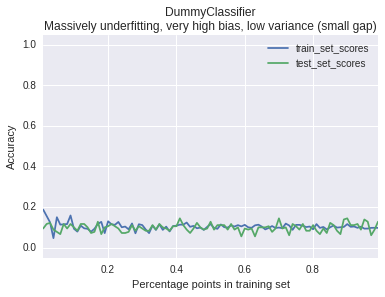

In [7]:
training_set_scores = np.zeros_like(train_set_sizes)
test_set_scores = np.zeros_like(train_set_sizes)

clf = DummyClassifier()

for training_set_idx, train_set_size in enumerate(train_set_sizes):
    X_train_subset, _, y_train_subset, _ = train_test_split(X_train, y_train, test_size=1-train_set_size, random_state=RANDOM_STATE)

    clf.fit(X_train_subset, y_train_subset)
    train_score = clf.score(X_train_subset, y_train_subset)
    training_set_scores[training_set_idx] = train_score
    
    test_score = clf.score(X_test, y_test)
    test_set_scores[training_set_idx] = test_score

df_scores = pd.DataFrame({'idx': train_set_sizes, 'test_set_scores': test_set_scores, 'train_set_scores': training_set_scores})
df_scores = df_scores.set_index('idx')
df_scores = df_scores[['train_set_scores', 'test_set_scores']] # reorder columns

df_scores.plot()
plt.ylim((-0.05, 1.05))
plt.ylabel("Accuracy")
plt.xlabel("Percentage points in training set")
plt.title("DummyClassifier\nMassively underfitting, very high bias, low variance (small gap)")

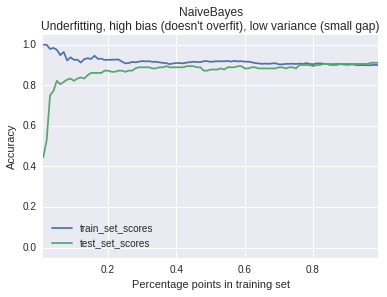

In [8]:
training_set_scores = np.zeros_like(train_set_sizes)
test_set_scores = np.zeros_like(train_set_sizes)

clf = naive_bayes.BernoulliNB()

for training_set_idx, train_set_size in enumerate(train_set_sizes):
    X_train_subset, _, y_train_subset, _ = train_test_split(X_train, y_train, test_size=1-train_set_size, random_state=RANDOM_STATE)

    clf.fit(X_train_subset, y_train_subset)
    train_score = clf.score(X_train_subset, y_train_subset)
    training_set_scores[training_set_idx] = train_score
    
    test_score = clf.score(X_test, y_test)
    test_set_scores[training_set_idx] = test_score

df_scores = pd.DataFrame({'idx': train_set_sizes, 'test_set_scores': test_set_scores, 'train_set_scores': training_set_scores})
df_scores = df_scores.set_index('idx')
df_scores = df_scores[['train_set_scores', 'test_set_scores']] # reorder columns

df_scores.plot()
plt.ylim((-0.05, 1.05))
plt.ylabel("Accuracy")
plt.xlabel("Percentage points in training set")
plt.title("NaiveBayes\nUnderfitting, high bias (doesn't overfit), low variance (small gap)")

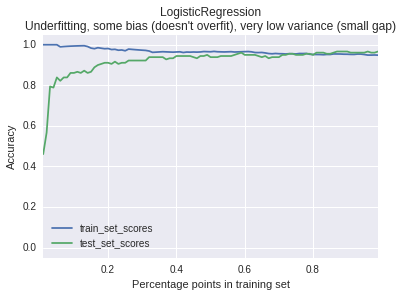

In [9]:
training_set_scores = np.zeros_like(train_set_sizes)
test_set_scores = np.zeros_like(train_set_sizes)

clf = linear_model.LogisticRegression()

for training_set_idx, train_set_size in enumerate(train_set_sizes):
    X_train_subset, _, y_train_subset, _ = train_test_split(X_train, y_train, test_size=1-train_set_size, random_state=RANDOM_STATE)

    clf.fit(X_train_subset, y_train_subset)
    train_score = clf.score(X_train_subset, y_train_subset)
    training_set_scores[training_set_idx] = train_score
    
    test_score = clf.score(X_test, y_test)
    test_set_scores[training_set_idx] = test_score

df_scores = pd.DataFrame({'idx': train_set_sizes, 'test_set_scores': test_set_scores, 'train_set_scores': training_set_scores})
df_scores = df_scores.set_index('idx')
df_scores = df_scores[['train_set_scores', 'test_set_scores']] # reorder columns

df_scores.plot()
plt.ylim((-0.05, 1.05))
plt.ylabel("Accuracy")
plt.xlabel("Percentage points in training set")
plt.title("LogisticRegression\nUnderfitting, some bias (doesn't overfit), very low variance (small gap)")

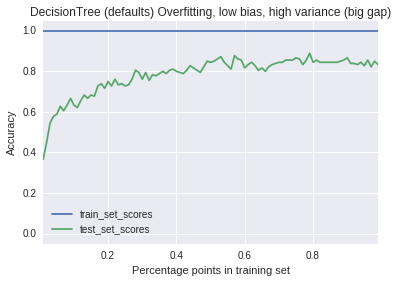

In [10]:
training_set_scores = np.zeros_like(train_set_sizes)
test_set_scores = np.zeros_like(train_set_sizes)

clf = tree.DecisionTreeClassifier()

for training_set_idx, train_set_size in enumerate(train_set_sizes):
    X_train_subset, _, y_train_subset, _ = train_test_split(X_train, y_train, test_size=1-train_set_size, random_state=RANDOM_STATE)

    clf.fit(X_train_subset, y_train_subset)
    train_score = clf.score(X_train_subset, y_train_subset)
    training_set_scores[training_set_idx] = train_score
    
    test_score = clf.score(X_test, y_test)
    test_set_scores[training_set_idx] = test_score

df_scores = pd.DataFrame({'idx': train_set_sizes, 'test_set_scores': test_set_scores, 'train_set_scores': training_set_scores})
df_scores = df_scores.set_index('idx')
df_scores = df_scores[['train_set_scores', 'test_set_scores']] # reorder columns

df_scores.plot()
plt.ylim((-0.05, 1.05))
plt.ylabel("Accuracy")
plt.xlabel("Percentage points in training set")
plt.title("DecisionTree (defaults) Overfitting, low bias, high variance (big gap)")

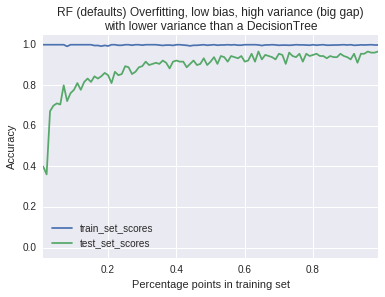

In [11]:
training_set_scores = np.zeros_like(train_set_sizes)
test_set_scores = np.zeros_like(train_set_sizes)

clf = RandomForestClassifier()

for training_set_idx, train_set_size in enumerate(train_set_sizes):
    X_train_subset, _, y_train_subset, _ = train_test_split(X_train, y_train, test_size=1-train_set_size, random_state=RANDOM_STATE)

    clf.fit(X_train_subset, y_train_subset)
    train_score = clf.score(X_train_subset, y_train_subset)
    training_set_scores[training_set_idx] = train_score
    
    test_score = clf.score(X_test, y_test)
    test_set_scores[training_set_idx] = test_score

df_scores = pd.DataFrame({'idx': train_set_sizes, 'test_set_scores': test_set_scores, 'train_set_scores': training_set_scores})
df_scores = df_scores.set_index('idx')
df_scores = df_scores[['train_set_scores', 'test_set_scores']] # reorder columns

df_scores.plot()
plt.ylim((-0.05, 1.05))
plt.ylabel("Accuracy")
plt.xlabel("Percentage points in training set")
plt.title("RF (defaults) Overfitting, low bias, high variance (big gap)\nwith lower variance than a DecisionTree")

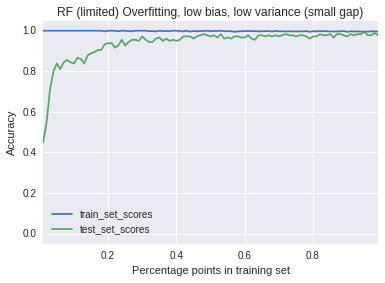

In [14]:
training_set_scores = np.zeros_like(train_set_sizes)
test_set_scores = np.zeros_like(train_set_sizes)

clf = RandomForestClassifier(n_estimators=50, max_depth=10)

for training_set_idx, train_set_size in enumerate(train_set_sizes):
    X_train_subset, _, y_train_subset, _ = train_test_split(X_train, y_train, test_size=1-train_set_size, random_state=RANDOM_STATE)

    clf.fit(X_train_subset, y_train_subset)
    train_score = clf.score(X_train_subset, y_train_subset)
    training_set_scores[training_set_idx] = train_score
    
    test_score = clf.score(X_test, y_test)
    test_set_scores[training_set_idx] = test_score

df_scores = pd.DataFrame({'idx': train_set_sizes, 'test_set_scores': test_set_scores, 'train_set_scores': training_set_scores})
df_scores = df_scores.set_index('idx')
df_scores = df_scores[['train_set_scores', 'test_set_scores']] # reorder columns

df_scores.plot()
plt.ylim((-0.05, 1.05))
plt.ylabel("Accuracy")
plt.xlabel("Percentage points in training set")
plt.title("RF (limited) Overfitting, low bias, low variance (small gap)")

# Next steps

* http://scikit-learn.org/stable/auto_examples/ensemble/plot_partial_dependence.html perhaps try a Partial Dependence plot
* sample hyperparameters using random search to tune RandomForest - can we beat the test-set score (above) by tuning using Cross Validation?. The Hyper Parameters for the last RF (n_estimators=50, max_depth=10) were hand guessed, we can probably find a better configuration 